In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# -------------------------
# Config
# -------------------------
SEQ_LEN = 8            # tokens per sentence (fixed)
EMB_DIM = 16           # embedding size per token
BATCH_SIZE = 256
EPOCHS = 200
LR = 1e-3
VOCAB_SIZE = 200       # number of distinct tokens (words)
HIDDEN = 512
KEY_DIM = SEQ_LEN * EMB_DIM
ALPHA = 0.8            # how strongly Alice tries to fool Eve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
# -------------------------
# Vocabulary + Dataset
# -------------------------
wordlist = [f"w{i}" for i in range(VOCAB_SIZE)]
stoi = {w:i for i,w in enumerate(wordlist)}
itos = {i:w for w,i in stoi.items()}

def sample_sentence():
    return [random.randrange(VOCAB_SIZE) for _ in range(SEQ_LEN)]

# build dataset
DATA_SIZE = 10000
dataset = [sample_sentence() for _ in range(DATA_SIZE)]

In [4]:
# split into train/val/test (70/15/15)
train_split = int(0.7 * DATA_SIZE)
val_split = int(0.85 * DATA_SIZE)
train_data = dataset[:train_split]
val_data = dataset[train_split:val_split]
test_data = dataset[val_split:]

In [5]:
def batch_from_data(data, batch_size):
    batch = random.sample(data, batch_size)
    return torch.tensor(batch, dtype=torch.long, device=device)

In [6]:
# -------------------------
# Models
# -------------------------
class AliceBobEveBase(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, HIDDEN),
            nn.ReLU(),
            nn.Linear(HIDDEN, HIDDEN),
            nn.ReLU(),
            nn.Linear(HIDDEN, output_dim)
        )
    def forward(self, x):
        return self.net(x)

In [7]:
Embedding = nn.Embedding(VOCAB_SIZE, EMB_DIM).to(device)

Alice = AliceBobEveBase(input_dim=KEY_DIM + KEY_DIM, output_dim=KEY_DIM).to(device)
Bob   = AliceBobEveBase(input_dim=KEY_DIM + KEY_DIM, output_dim=KEY_DIM).to(device)
Eve   = AliceBobEveBase(input_dim=KEY_DIM, output_dim=KEY_DIM).to(device)

embed2logits = nn.Linear(EMB_DIM, VOCAB_SIZE).to(device)

In [8]:
# -------------------------
# Keys
# -------------------------
def generate_keys(batch_size):
    return torch.rand(batch_size, KEY_DIM, device=device)

In [9]:
# -------------------------
# Losses & Optims
# -------------------------
celoss = nn.CrossEntropyLoss()
opt_Eve = optim.Adam(Eve.parameters(), lr=LR)

# 🔑 Option 1 fix: include embed2logits in opt_AB
opt_AB = optim.Adam(
    list(Alice.parameters()) + list(Bob.parameters()) + list(embed2logits.parameters()),
    lr=LR
)

In [10]:
# -------------------------
# Helpers
# -------------------------
def flatten_embeddings(emb):
    return emb.reshape(emb.size(0), -1)

def unflatten_embeddings(vec):
    return vec.reshape(-1, SEQ_LEN, EMB_DIM)

def logits_from_flat_embeddings(flat_emb):
    emb = unflatten_embeddings(flat_emb)
    logits = embed2logits(emb.reshape(-1, EMB_DIM))
    return logits.view(-1, SEQ_LEN, VOCAB_SIZE)

def token_accuracy_from_logits(logits, targets):
    pred = logits.argmax(dim=-1)
    return (pred == targets).float().mean().item()

def decode_tokens(token_ids):
    return " ".join([itos.get(int(t),"UNK") for t in token_ids])

In [11]:
# -------------------------
# Training loop
# -------------------------
history = {"bob_loss":[], "eve_loss":[], "bob_acc":[], "eve_acc":[]}

for epoch in range(1, EPOCHS+1):
    # --- Train Eve ---
    msgs = batch_from_data(train_data, BATCH_SIZE)
    keys = generate_keys(BATCH_SIZE)
    emb = Embedding(msgs)
    flat_emb = flatten_embeddings(emb)
    with torch.no_grad():
        ciphertext = Alice(torch.cat([flat_emb, keys], dim=1)).detach()
    eve_out_flat = Eve(ciphertext)
    eve_logits = logits_from_flat_embeddings(eve_out_flat)
    loss_eve = celoss(eve_logits.reshape(-1, VOCAB_SIZE), msgs.reshape(-1))
    opt_Eve.zero_grad()
    loss_eve.backward()
    opt_Eve.step()

    # --- Train Alice + Bob ---
    msgs = batch_from_data(train_data, BATCH_SIZE)
    keys = generate_keys(BATCH_SIZE)
    emb = Embedding(msgs)
    flat_emb = flatten_embeddings(emb)
    ciphertext_ab = Alice(torch.cat([flat_emb, keys], dim=1))
    bob_out_flat = Bob(torch.cat([ciphertext_ab, keys], dim=1))
    bob_logits = logits_from_flat_embeddings(bob_out_flat)
    with torch.no_grad():
        eve_logits_ab = logits_from_flat_embeddings(Eve(ciphertext_ab.detach()))
    loss_bob = celoss(bob_logits.reshape(-1, VOCAB_SIZE), msgs.reshape(-1))
    loss_eve_ab = celoss(eve_logits_ab.reshape(-1, VOCAB_SIZE), msgs.reshape(-1))
    alicebob_loss = loss_bob - ALPHA * loss_eve_ab.detach()

    opt_AB.zero_grad()
    alicebob_loss.backward()
    opt_AB.step()

    # --- Eval on val set ---
    with torch.no_grad():
        val_batch = batch_from_data(val_data, BATCH_SIZE)
        val_keys = generate_keys(BATCH_SIZE)
        val_emb = Embedding(val_batch)
        val_flat = flatten_embeddings(val_emb)
        val_ct = Alice(torch.cat([val_flat, val_keys], dim=1))
        bob_out_flat = Bob(torch.cat([val_ct, val_keys], dim=1))
        bob_logits_val = logits_from_flat_embeddings(bob_out_flat)
        bob_acc = token_accuracy_from_logits(bob_logits_val, val_batch)
        eve_logits_val = logits_from_flat_embeddings(Eve(val_ct))
        eve_acc = token_accuracy_from_logits(eve_logits_val, val_batch)

    history["bob_loss"].append(loss_bob.item())
    history["eve_loss"].append(loss_eve.item())
    history["bob_acc"].append(bob_acc)
    history["eve_acc"].append(eve_acc)

    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{EPOCHS} | Bob loss {loss_bob.item():.4f} | Eve loss {loss_eve.item():.4f} | Bob acc {bob_acc:.3f} | Eve acc {eve_acc:.3f}")


Epoch 20/200 | Bob loss 5.3044 | Eve loss 5.3059 | Bob acc 0.007 | Eve acc 0.006
Epoch 40/200 | Bob loss 5.2878 | Eve loss 5.2796 | Bob acc 0.007 | Eve acc 0.009
Epoch 60/200 | Bob loss 5.1790 | Eve loss 5.1734 | Bob acc 0.009 | Eve acc 0.011
Epoch 80/200 | Bob loss 5.0144 | Eve loss 5.0185 | Bob acc 0.019 | Eve acc 0.019
Epoch 100/200 | Bob loss 4.7839 | Eve loss 4.7561 | Bob acc 0.032 | Eve acc 0.028
Epoch 120/200 | Bob loss 4.4905 | Eve loss 4.4580 | Bob acc 0.035 | Eve acc 0.038
Epoch 140/200 | Bob loss 4.0904 | Eve loss 4.0951 | Bob acc 0.062 | Eve acc 0.059
Epoch 160/200 | Bob loss 3.6327 | Eve loss 3.6738 | Bob acc 0.089 | Eve acc 0.088
Epoch 180/200 | Bob loss 3.1655 | Eve loss 3.2088 | Bob acc 0.118 | Eve acc 0.126
Epoch 200/200 | Bob loss 2.7733 | Eve loss 2.8129 | Bob acc 0.174 | Eve acc 0.182


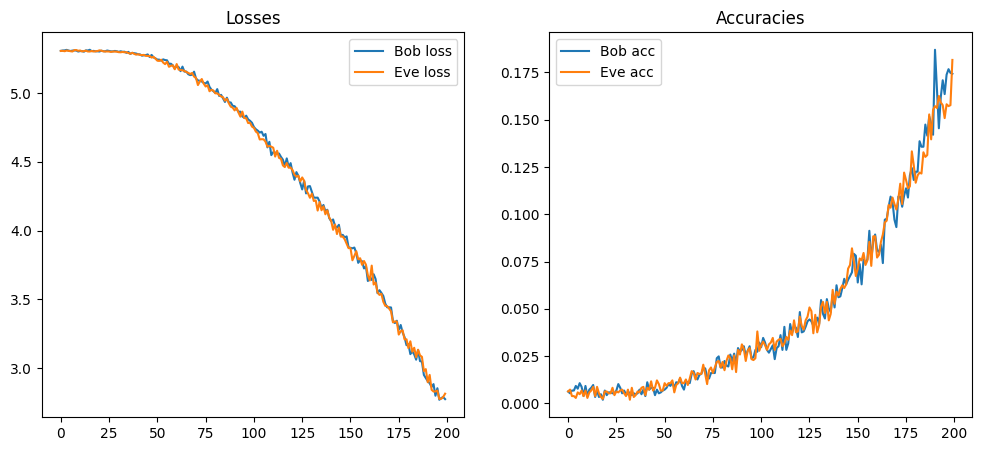

In [12]:
# -------------------------
# Plot training curves
# -------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history["bob_loss"], label="Bob loss")
plt.plot(history["eve_loss"], label="Eve loss")
plt.legend(); plt.title("Losses")

plt.subplot(1,2,2)
plt.plot(history["bob_acc"], label="Bob acc")
plt.plot(history["eve_acc"], label="Eve acc")
plt.legend(); plt.title("Accuracies")
plt.show()

In [13]:

# -------------------------
# Test sample sentences
# -------------------------
print("\n=== SAMPLE TESTS ===")
test_batch = batch_from_data(test_data, 6)
test_keys = generate_keys(6)
with torch.no_grad():
    flat = flatten_embeddings(Embedding(test_batch))
    ct = Alice(torch.cat([flat, test_keys], dim=1))
    bob_out_flat = Bob(torch.cat([ct, test_keys], dim=1))
    bob_logits = logits_from_flat_embeddings(bob_out_flat)
    bob_pred = bob_logits.argmax(dim=-1)
    eve_logits = logits_from_flat_embeddings(Eve(ct))
    eve_pred = eve_logits.argmax(dim=-1)

for i in range(test_batch.size(0)):
    print("Original :", decode_tokens(test_batch[i].cpu().numpy()))
    print("Bob Pred :", decode_tokens(bob_pred[i].cpu().numpy()))
    print("Eve Pred :", decode_tokens(eve_pred[i].cpu().numpy()))
    print("-"*60)


=== SAMPLE TESTS ===
Original : w69 w95 w19 w61 w34 w144 w123 w160
Bob Pred : w129 w95 w116 w61 w20 w39 w147 w6
Eve Pred : w129 w95 w19 w160 w22 w112 w24 w6
------------------------------------------------------------
Original : w190 w134 w185 w185 w22 w81 w188 w128
Bob Pred : w141 w59 w30 w30 w150 w114 w183 w56
Eve Pred : w180 w134 w36 w185 w70 w13 w188 w147
------------------------------------------------------------
Original : w175 w55 w71 w84 w118 w11 w22 w149
Bob Pred : w72 w55 w92 w159 w46 w11 w50 w182
Eve Pred : w157 w165 w36 w106 w91 w83 w37 w182
------------------------------------------------------------
Original : w170 w73 w129 w38 w118 w139 w177 w0
Bob Pred : w106 w142 w4 w116 w46 w95 w177 w129
Eve Pred : w39 w71 w43 w116 w95 w53 w116 w0
------------------------------------------------------------
Original : w125 w68 w189 w83 w46 w39 w75 w11
Bob Pred : w125 w68 w27 w121 w46 w79 w104 w83
Eve Pred : w125 w157 w26 w83 w108 w86 w104 w63
----------------------------------------

## Dropout + Bigger Networks - next version

In [15]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [16]:
# -------------------------
# Config
# -------------------------
SEQ_LEN = 8             # tokens per sentence
EMB_DIM = 16            # embedding size
BATCH_SIZE = 256
EPOCHS = 1000
LR = 1e-3
VOCAB_SIZE = 50         # smaller vocab for easier learning
HIDDEN = 1024           # bigger hidden size
KEY_DIM = SEQ_LEN * EMB_DIM
ALPHA = 0.8             # how strongly Alice fools Eve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [17]:

# -------------------------
# Vocabulary + Dataset
# -------------------------
wordlist = [f"w{i}" for i in range(VOCAB_SIZE)]
stoi = {w:i for i,w in enumerate(wordlist)}
itos = {i:w for w,i in stoi.items()}

def sample_sentence():
    return [random.randrange(VOCAB_SIZE) for _ in range(SEQ_LEN)]

DATA_SIZE = 10000
dataset = [sample_sentence() for _ in range(DATA_SIZE)]

In [18]:
# split 70/15/15
train_split = int(0.7 * DATA_SIZE)
val_split = int(0.85 * DATA_SIZE)
train_data = dataset[:train_split]
val_data = dataset[train_split:val_split]
test_data = dataset[val_split:]

def batch_from_data(data, batch_size):
    batch = random.sample(data, batch_size)
    return torch.tensor(batch, dtype=torch.long, device=device)

In [19]:
# -------------------------
# Models
# -------------------------
class AliceBobEveBase(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, HIDDEN),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(HIDDEN, HIDDEN),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(HIDDEN, HIDDEN),
            nn.ReLU(),
            nn.Linear(HIDDEN, output_dim)
        )
    def forward(self, x):
        return self.net(x)

Embedding = nn.Embedding(VOCAB_SIZE, EMB_DIM).to(device)

Alice = AliceBobEveBase(input_dim=KEY_DIM + KEY_DIM, output_dim=KEY_DIM).to(device)
Bob   = AliceBobEveBase(input_dim=KEY_DIM + KEY_DIM, output_dim=KEY_DIM).to(device)
Eve   = AliceBobEveBase(input_dim=KEY_DIM, output_dim=KEY_DIM).to(device)

embed2logits = nn.Linear(EMB_DIM, VOCAB_SIZE).to(device)

In [20]:
# -------------------------
# Keys
# -------------------------
def generate_keys(batch_size):
    # fixed random key per sample
    return torch.rand(batch_size, KEY_DIM, device=device)

In [21]:
# -------------------------
# Losses & Optimizers
# -------------------------
celoss = nn.CrossEntropyLoss()
opt_Eve = optim.Adam(Eve.parameters(), lr=LR)
opt_AB = optim.Adam(
    list(Alice.parameters()) + list(Bob.parameters()) + list(embed2logits.parameters()),
    lr=LR
)

In [22]:
# -------------------------
# Helpers
# -------------------------
def flatten_embeddings(emb):
    return emb.reshape(emb.size(0), -1)

def unflatten_embeddings(vec):
    return vec.reshape(-1, SEQ_LEN, EMB_DIM)

def logits_from_flat_embeddings(flat_emb):
    emb = unflatten_embeddings(flat_emb)
    logits = embed2logits(emb.reshape(-1, EMB_DIM))
    return logits.view(-1, SEQ_LEN, VOCAB_SIZE)

def token_accuracy_from_logits(logits, targets):
    pred = logits.argmax(dim=-1)
    return (pred == targets).float().mean().item()

def decode_tokens(token_ids):
    return " ".join([itos.get(int(t),"UNK") for t in token_ids])

In [23]:
# -------------------------
# Training loop
# -------------------------
history = {"bob_loss":[], "eve_loss":[], "bob_acc":[], "eve_acc":[]}

for epoch in range(1, EPOCHS+1):
    # --- Train Eve ---
    msgs = batch_from_data(train_data, BATCH_SIZE)
    keys = generate_keys(BATCH_SIZE)
    emb = Embedding(msgs)
    flat_emb = flatten_embeddings(emb)
    with torch.no_grad():
        ciphertext = Alice(torch.cat([flat_emb, keys], dim=1)).detach()
    eve_out_flat = Eve(ciphertext)
    eve_logits = logits_from_flat_embeddings(eve_out_flat)
    loss_eve = celoss(eve_logits.reshape(-1, VOCAB_SIZE), msgs.reshape(-1))
    opt_Eve.zero_grad()
    loss_eve.backward()
    opt_Eve.step()

    # --- Train Alice + Bob ---
    msgs = batch_from_data(train_data, BATCH_SIZE)
    keys = generate_keys(BATCH_SIZE)
    emb = Embedding(msgs)
    flat_emb = flatten_embeddings(emb)
    ciphertext_ab = Alice(torch.cat([flat_emb, keys], dim=1))
    bob_out_flat = Bob(torch.cat([ciphertext_ab, keys], dim=1))
    bob_logits = logits_from_flat_embeddings(bob_out_flat)
    with torch.no_grad():
        eve_logits_ab = logits_from_flat_embeddings(Eve(ciphertext_ab.detach()))
    loss_bob = celoss(bob_logits.reshape(-1, VOCAB_SIZE), msgs.reshape(-1))
    loss_eve_ab = celoss(eve_logits_ab.reshape(-1, VOCAB_SIZE), msgs.reshape(-1))
    alicebob_loss = loss_bob - ALPHA * loss_eve_ab.detach()

    opt_AB.zero_grad()
    alicebob_loss.backward()
    opt_AB.step()

    # --- Eval on val set ---
    with torch.no_grad():
        val_batch = batch_from_data(val_data, BATCH_SIZE)
        val_keys = generate_keys(BATCH_SIZE)
        val_emb = Embedding(val_batch)
        val_flat = flatten_embeddings(val_emb)
        val_ct = Alice(torch.cat([val_flat, val_keys], dim=1))
        bob_out_flat = Bob(torch.cat([val_ct, val_keys], dim=1))
        bob_logits_val = logits_from_flat_embeddings(bob_out_flat)
        bob_acc = token_accuracy_from_logits(bob_logits_val, val_batch)
        eve_logits_val = logits_from_flat_embeddings(Eve(val_ct))
        eve_acc = token_accuracy_from_logits(eve_logits_val, val_batch)

    history["bob_loss"].append(loss_bob.item())
    history["eve_loss"].append(loss_eve.item())
    history["bob_acc"].append(bob_acc)
    history["eve_acc"].append(eve_acc)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{EPOCHS} | Bob loss {loss_bob.item():.4f} | Eve loss {loss_eve.item():.4f} | Bob acc {bob_acc:.3f} | Eve acc {eve_acc:.3f}")

Epoch 100/1000 | Bob loss 3.8325 | Eve loss 3.8480 | Bob acc 0.026 | Eve acc 0.031
Epoch 200/1000 | Bob loss 3.7279 | Eve loss 3.7252 | Bob acc 0.045 | Eve acc 0.039
Epoch 300/1000 | Bob loss 3.3855 | Eve loss 3.4606 | Bob acc 0.067 | Eve acc 0.069
Epoch 400/1000 | Bob loss 3.2587 | Eve loss 3.2823 | Bob acc 0.087 | Eve acc 0.079
Epoch 500/1000 | Bob loss 3.2022 | Eve loss 3.2593 | Bob acc 0.087 | Eve acc 0.081
Epoch 600/1000 | Bob loss 3.1555 | Eve loss 3.1757 | Bob acc 0.103 | Eve acc 0.084
Epoch 700/1000 | Bob loss 3.0845 | Eve loss 3.1633 | Bob acc 0.102 | Eve acc 0.086
Epoch 800/1000 | Bob loss 3.0440 | Eve loss 3.0747 | Bob acc 0.109 | Eve acc 0.106
Epoch 900/1000 | Bob loss 3.0151 | Eve loss 3.0641 | Bob acc 0.111 | Eve acc 0.110
Epoch 1000/1000 | Bob loss 3.0153 | Eve loss 3.0649 | Bob acc 0.116 | Eve acc 0.111


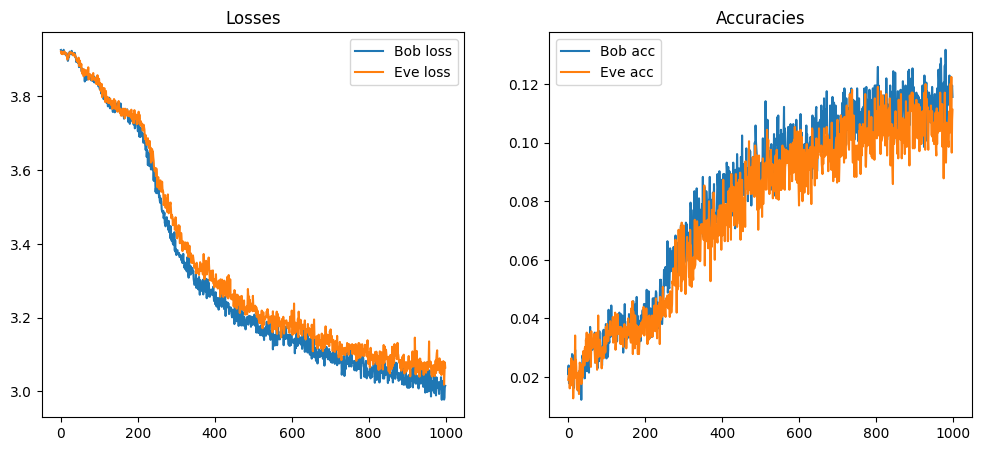

In [24]:
# -------------------------
# Plot training curves
# -------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history["bob_loss"], label="Bob loss")
plt.plot(history["eve_loss"], label="Eve loss")
plt.legend(); plt.title("Losses")

plt.subplot(1,2,2)
plt.plot(history["bob_acc"], label="Bob acc")
plt.plot(history["eve_acc"], label="Eve acc")
plt.legend(); plt.title("Accuracies")
plt.show()

In [25]:
# -------------------------
# Test sample sentences
# -------------------------
print("\n=== SAMPLE TESTS ===")
test_batch = batch_from_data(test_data, 6)
test_keys = generate_keys(6)
with torch.no_grad():
    flat = flatten_embeddings(Embedding(test_batch))
    ct = Alice(torch.cat([flat, test_keys], dim=1))
    bob_out_flat = Bob(torch.cat([ct, test_keys], dim=1))
    bob_logits = logits_from_flat_embeddings(bob_out_flat)
    bob_pred = bob_logits.argmax(dim=-1)
    eve_logits = logits_from_flat_embeddings(Eve(ct))
    eve_pred = eve_logits.argmax(dim=-1)

for i in range(test_batch.size(0)):
    print("Original :", decode_tokens(test_batch[i].cpu().numpy()))
    print("Bob Pred :", decode_tokens(bob_pred[i].cpu().numpy()))
    print("Eve Pred :", decode_tokens(eve_pred[i].cpu().numpy()))
    print("-"*60)


=== SAMPLE TESTS ===
Original : w4 w23 w45 w2 w40 w20 w24 w30
Bob Pred : w39 w7 w22 w4 w43 w8 w29 w0
Eve Pred : w39 w49 w22 w14 w46 w8 w10 w0
------------------------------------------------------------
Original : w46 w25 w37 w9 w27 w43 w5 w13
Bob Pred : w48 w10 w6 w0 w47 w46 w0 w49
Eve Pred : w46 w10 w6 w41 w30 w18 w46 w13
------------------------------------------------------------
Original : w14 w35 w23 w31 w28 w4 w16 w21
Bob Pred : w27 w0 w23 w7 w48 w29 w38 w20
Eve Pred : w25 w45 w23 w35 w27 w12 w36 w16
------------------------------------------------------------
Original : w49 w26 w45 w3 w42 w35 w16 w36
Bob Pred : w49 w27 w45 w35 w18 w35 w26 w6
Eve Pred : w49 w27 w11 w19 w19 w35 w28 w29
------------------------------------------------------------
Original : w47 w42 w8 w20 w19 w49 w30 w28
Bob Pred : w43 w27 w8 w5 w10 w17 w1 w13
Eve Pred : w43 w19 w13 w38 w10 w49 w28 w49
------------------------------------------------------------
Original : w1 w28 w23 w0 w15 w2 w45 w24
Bob Pred : 